In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, Adadelta, Adagrad, RMSprop
import random

### Comapring the performances of disparate optimizers(SGD vs Adam vs Adadelta vs Adagrad vs RMSprop)

In [2]:
fmnist = datasets.FashionMNIST(root='./data', train=True, download=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
tr_images.shape, tr_targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [3]:
val_fmnist = datasets.FashionMNIST(root='./data', train=False, download=True)
val_images = val_fmnist.data
val_targets = val_fmnist.targets
val_images.shape, val_targets.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Training the neural net with SGD optimizer

In [5]:
class FMNISTDataset(Dataset):
    """Class which fetches the dataset"""
    def __init__(self, S, y):
        S = S.float()/255 # Converting the input into floating point numbers and scaling the input to (0, 1)
        S = S.view(-1, 28*28) # Flattening the input to 28*28 numeric values
        self.S, self.y = S, y
    def __getitem__(self, iS):
        """ This method contains logic for what should be returned 
            when we ask for iS th datapoint
        """
        S, y = self.S[iS], self.y[iS]
        return S.to(device), y.to(device)
    def __len__(self):
        """ This method computes the number of datapoints in the dataset
        """
        return len(self.S)

In [6]:
def get_model():
    """ This function creates a neural net with one hidden layer of 1000 neurons and a 10 layer output layer,
        the loss function(cross entropy) and the optmizer(SGD)"""
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [7]:
def train_batch(S, y, SNet, optimizer, loss_fn):
    """This function will train the neural net on a 
       batch of images"""
    SNet.train() # Tells the neural net that you are training it
    prediction = SNet(S) 
    batch_loss = loss_fn(prediction, y) # Computing the loss value
    batch_loss.backward()  # Computing the gradients of the loss fn wrt the parameters of the neural net
    optimizer.step() # Updating the values of the parameters of the neural net 
    optimizer.zero_grad() # Flush gradients memory for next batch of calculations
    return batch_loss.item()

In [8]:
def accuracy(S, y, SNet):
    """This function calculates whether the model's predictions for each input in the batch are correct, 
       comparing the predicted class (from the argmax of the output logits) with the true class labels.
       It then returns a list of booleans, where each element is True if the corresponding prediction 
       was correct and False if it was incorrect."""
    SNet.eval()
    with torch.no_grad():
        prediction = SNet(S)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [9]:
def get_data():
    """This function prepares and returns two data loaders: one for training (with batching and shuffling) 
       and one for validation (with the full validation set)"""
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [10]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [11]:
@torch.no_grad()
def val_loss(S, y, SNet):
    """This function computes the validation loss of the neural net"""
    prediction = SNet(S)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [12]:
# Training the neural net with the SGD optmizer
train_losses, train_accuracies = [], [] 
val_losses, val_accuracies = [], [] # Initializing the lists which will contain training accuracy, training loss, validation accuracy, 
# validation loss at every epoch
for epoch in range(10):  # Training the neural net for 10 epochs
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], [] # Initializing the lists that will contain the accuracy and loss value at every batch
    for iS, batch in enumerate(iter(trn_dl)): # Creating batches of training data by iterating through the dataloader
        S, y = batch
        batch_loss = train_batch(S, y, SNet, optimizer, loss_fn) # train the batch with the aid of the train_batch function and compute the loss
        train_epoch_losses.append(batch_loss) # Storing the training batch loss to the train_epoch_losses list
    train_epoch_loss = np.array(train_epoch_losses).mean() # Computing the training loss for the epoch
    for iS, batch in enumerate(iter(trn_dl)):
        S, y = batch
        is_correct = accuracy(S, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies) # Computing the training accuracy for the epoch
    for iS, batch in enumerate(iter(val_dl)):
        S, y = batch
        val_is_correct = accuracy(S, y, SNet)
        validation_loss = val_loss(S, y, SNet)
    val_epoch_accuracy = np.mean(val_is_correct) # Computing the validation accuacy for the epoch
    # Storing the training and validation loss values and accuracy in the respective lists
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


In [13]:
train_losses, train_accuracies, val_losses, val_accuracies

([0.8427749921560288,
  0.5362489481925964,
  0.4820352461417516,
  0.45401142229239144,
  0.43510214465061825,
  0.41944201511144635,
  0.40720337888002395,
  0.39578413512706756,
  0.3862082105159759,
  0.37739283842245736],
 [0.8068166666666666,
  0.8303333333333334,
  0.8351,
  0.8484166666666667,
  0.8442333333333333,
  0.8594333333333334,
  0.8566666666666667,
  0.8613666666666666,
  0.8724,
  0.8707],
 [0.6075092554092407,
  0.5230603218078613,
  0.5029959082603455,
  0.4714600443840027,
  0.4769306778907776,
  0.4473836421966553,
  0.44970595836639404,
  0.438082218170166,
  0.41431084275245667,
  0.4133329689502716],
 [0.7949,
  0.8175,
  0.8211,
  0.8334,
  0.8245,
  0.8423,
  0.8395,
  0.8466,
  0.8541,
  0.8523])

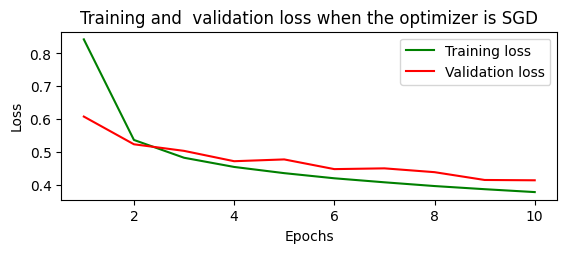

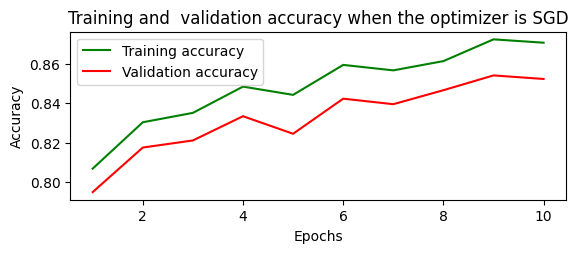

In [14]:
# Plotting the training and validation loss values
epochs = np.arange(10) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and  validation loss when the optimizer is SGD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Plotting the training and validation accuracy values
plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and  validation accuracy when the optimizer is SGD")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Training the neural net with the Adam optimizer

In [15]:
def get_model():
    """ This function creates a neural net with one hidden layer of 1000 neurons and a 10 layer output layer,
        the loss function(cross entropy) and the optmizer(Adam)"""
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [16]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [17]:
# Training the neural net with the Adam optmizer
train_losses, train_accuracies = [], [] 
val_losses, val_accuracies = [], [] # Initializing the lists which will contain training accuracy, training loss, validation accuracy, 
# validation loss at every epoch
for epoch in range(10):  # Training the neural net for 10 epochs
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], [] # Initializing the lists that will contain the accuracy and loss value at every batch
    for iS, batch in enumerate(iter(trn_dl)): # Creating batches of training data by iterating through the dataloader
        S, y = batch
        batch_loss = train_batch(S, y, SNet, optimizer, loss_fn) # train the batch with the aid of the train_batch function and compute the loss
        train_epoch_losses.append(batch_loss) # Storing the training batch loss to the train_epoch_losses list
    train_epoch_loss = np.array(train_epoch_losses).mean() # Computing the training loss for the epoch
    for iS, batch in enumerate(iter(trn_dl)):
        S, y = batch
        is_correct = accuracy(S, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies) # Computing the training accuracy for the epoch
    for iS, batch in enumerate(iter(val_dl)):
        S, y = batch
        val_is_correct = accuracy(S, y, SNet)
        validation_loss = val_loss(S, y, SNet)
    val_epoch_accuracy = np.mean(val_is_correct) # Computing the validation accuacy for the epoch
    # Storing the training and validation loss values and accuracy in the respective lists
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


In [18]:
train_losses, train_accuracies, val_losses, val_accuracies

([0.5352910393118858,
  0.4379887369275093,
  0.41937757230997086,
  0.4050290839672089,
  0.398931982789437,
  0.3878370537638664,
  0.38182754102746647,
  0.38134571519295374,
  0.3705074501345555,
  0.3699205189168453],
 [0.8457166666666667,
  0.8422333333333333,
  0.8651333333333333,
  0.8664,
  0.86785,
  0.8747666666666667,
  0.8730333333333333,
  0.8748333333333334,
  0.8663,
  0.8664],
 [0.4827282130718231,
  0.49564141035079956,
  0.44179072976112366,
  0.4343072175979614,
  0.44698578119277954,
  0.4276959002017975,
  0.43795913457870483,
  0.43803349137306213,
  0.4843040406703949,
  0.4778401255607605],
 [0.831,
  0.825,
  0.8445,
  0.8482,
  0.8485,
  0.8513,
  0.8519,
  0.8516,
  0.8426,
  0.8402])

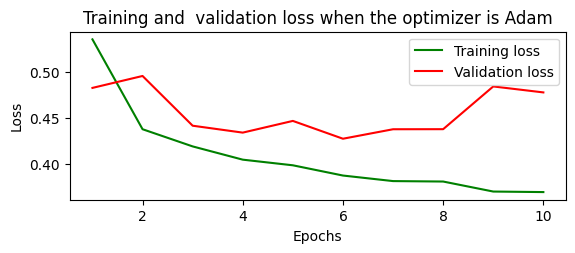

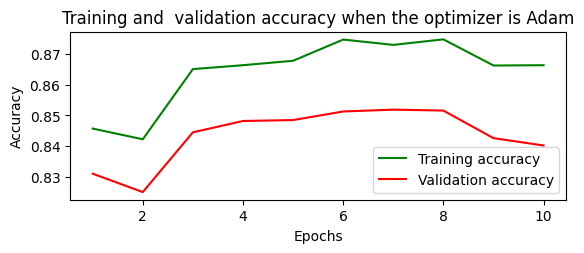

In [19]:
# Plotting the training and validation loss values
epochs = np.arange(10) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and  validation loss when the optimizer is Adam")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Plotting the training and validation accuracy values
plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and  validation accuracy when the optimizer is Adam")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Training the neural net with the Adadelta optimizer

In [20]:
def get_model():
    """ This function creates a neural net with one hidden layer of 1000 neurons and a 10 layer output layer,
        the loss function(cross entropy) and the optmizer(Adadelta)"""
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adadelta(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [23]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [24]:
# Training the neural net with the Adadelta optmizer
train_losses, train_accuracies = [], [] 
val_losses, val_accuracies = [], [] # Initializing the lists which will contain training accuracy, training loss, validation accuracy, 
# validation loss at every epoch
for epoch in range(10):  # Training the neural net for 10 epochs
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], [] # Initializing the lists that will contain the accuracy and loss value at every batch
    for iS, batch in enumerate(iter(trn_dl)): # Creating batches of training data by iterating through the dataloader
        S, y = batch
        batch_loss = train_batch(S, y, SNet, optimizer, loss_fn) # train the batch with the aid of the train_batch function and compute the loss
        train_epoch_losses.append(batch_loss) # Storing the training batch loss to the train_epoch_losses list
    train_epoch_loss = np.array(train_epoch_losses).mean() # Computing the training loss for the epoch
    for iS, batch in enumerate(iter(trn_dl)):
        S, y = batch
        is_correct = accuracy(S, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies) # Computing the training accuracy for the epoch
    for iS, batch in enumerate(iter(val_dl)):
        S, y = batch
        val_is_correct = accuracy(S, y, SNet)
        validation_loss = val_loss(S, y, SNet)
    val_epoch_accuracy = np.mean(val_is_correct) # Computing the validation accuacy for the epoch
    # Storing the training and validation loss values and accuracy in the respective lists
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


In [25]:
train_losses, train_accuracies, val_losses, val_accuracies

([1.0569977468490601,
  0.646578105465571,
  0.5634599465767542,
  0.5205879213730494,
  0.49338853736718497,
  0.4738396858294805,
  0.4589823002497355,
  0.44673533193270365,
  0.43670257491668063,
  0.42745357958873115],
 [0.75975,
  0.8026333333333333,
  0.8187333333333333,
  0.8313666666666667,
  0.8369166666666666,
  0.8427166666666667,
  0.846,
  0.85045,
  0.8518833333333333,
  0.85335],
 [0.7339500188827515,
  0.6122646927833557,
  0.5610358119010925,
  0.5275346040725708,
  0.5092931985855103,
  0.4923613369464874,
  0.4815070331096649,
  0.47017714381217957,
  0.4640823304653168,
  0.4592231512069702],
 [0.7479, 0.79, 0.8081, 0.82, 0.8234, 0.831, 0.832, 0.8347, 0.8363, 0.8386])

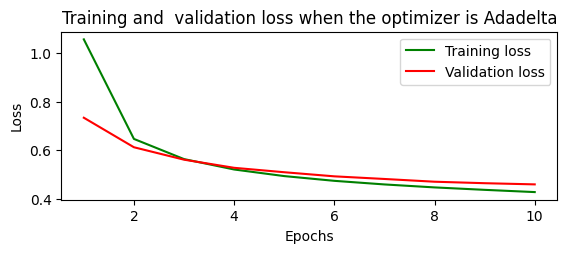

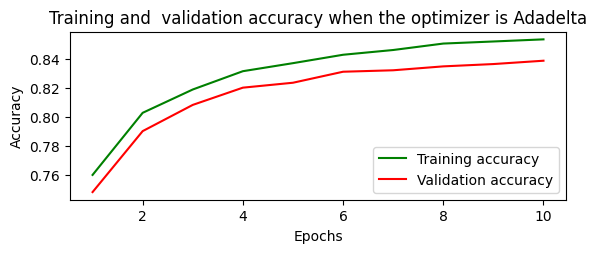

In [26]:
# Plotting the training and validation loss values
epochs = np.arange(10) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and  validation loss when the optimizer is Adadelta")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Plotting the training and validation accuracy values
plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and  validation accuracy when the optimizer is Adadelta")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Training the neural net with the Adagrad optimizer

In [27]:
def get_model():
    """ This function creates a neural net with one hidden layer of 1000 neurons and a 10 layer output layer,
        the loss function(cross entropy) and the optmizer(Adagrad)"""
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adagrad(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [28]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [29]:
# Training the neural net with the Adagrad optmizer
train_losses, train_accuracies = [], [] 
val_losses, val_accuracies = [], [] # Initializing the lists which will contain training accuracy, training loss, validation accuracy, 
# validation loss at every epoch
for epoch in range(10):  # Training the neural net for 10 epochs
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], [] # Initializing the lists that will contain the accuracy and loss value at every batch
    for iS, batch in enumerate(iter(trn_dl)): # Creating batches of training data by iterating through the dataloader
        S, y = batch
        batch_loss = train_batch(S, y, SNet, optimizer, loss_fn) # train the batch with the aid of the train_batch function and compute the loss
        train_epoch_losses.append(batch_loss) # Storing the training batch loss to the train_epoch_losses list
    train_epoch_loss = np.array(train_epoch_losses).mean() # Computing the training loss for the epoch
    for iS, batch in enumerate(iter(trn_dl)):
        S, y = batch
        is_correct = accuracy(S, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies) # Computing the training accuracy for the epoch
    for iS, batch in enumerate(iter(val_dl)):
        S, y = batch
        val_is_correct = accuracy(S, y, SNet)
        validation_loss = val_loss(S, y, SNet)
    val_epoch_accuracy = np.mean(val_is_correct) # Computing the validation accuacy for the epoch
    # Storing the training and validation loss values and accuracy in the respective lists
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


In [30]:
train_losses, train_accuracies, val_losses, val_accuracies

([0.48637476391792295,
  0.3623976120511691,
  0.3295471921165784,
  0.3088645182490349,
  0.29415447588761645,
  0.28213708781401314,
  0.2722456413884958,
  0.26364464398225146,
  0.2568438895702362,
  0.2502239005535841],
 [0.8670333333333333,
  0.8792833333333333,
  0.8852166666666667,
  0.89585,
  0.8992,
  0.9037833333333334,
  0.9054666666666666,
  0.9085333333333333,
  0.9110666666666667,
  0.9107],
 [0.414976567029953,
  0.3806847631931305,
  0.3699186146259308,
  0.34740468859672546,
  0.3395746946334839,
  0.3313666582107544,
  0.3304401636123657,
  0.3228324055671692,
  0.32119056582450867,
  0.32038846611976624],
 [0.8528,
  0.8649,
  0.8672,
  0.8757,
  0.878,
  0.8816,
  0.8818,
  0.8825,
  0.8846,
  0.8824])

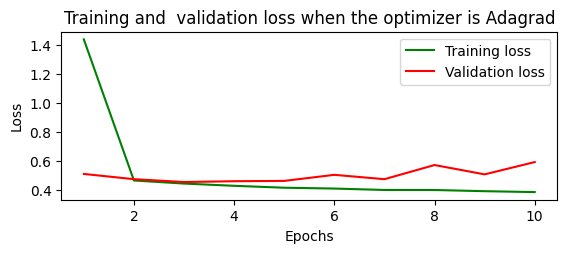

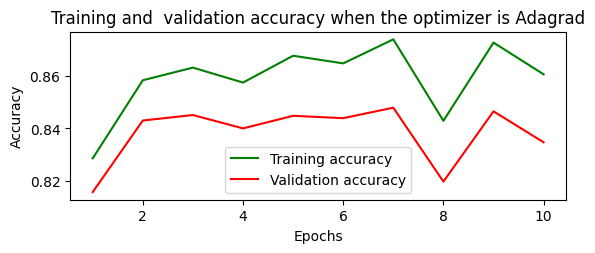

In [35]:
# Plotting the training and validation loss values
epochs = np.arange(10) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and  validation loss when the optimizer is Adagrad")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Plotting the training and validation accuracy values
plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and  validation accuracy when the optimizer is Adagrad")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Training the neural net with the RMSprop optimizer

In [31]:
def get_model():
    """ This function creates a neural net with one hidden layer of 1000 neurons and a 10 layer output layer,
        the loss function(cross entropy) and the optmizer(RMSprop)"""
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = RMSprop(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [32]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [33]:
# Training the neural net with the RMSprop optmizer
train_losses, train_accuracies = [], [] 
val_losses, val_accuracies = [], [] # Initializing the lists which will contain training accuracy, training loss, validation accuracy, 
# validation loss at every epoch
for epoch in range(10):  # Training the neural net for 10 epochs
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], [] # Initializing the lists that will contain the accuracy and loss value at every batch
    for iS, batch in enumerate(iter(trn_dl)): # Creating batches of training data by iterating through the dataloader
        S, y = batch
        batch_loss = train_batch(S, y, SNet, optimizer, loss_fn) # train the batch with the aid of the train_batch function and compute the loss
        train_epoch_losses.append(batch_loss) # Storing the training batch loss to the train_epoch_losses list
    train_epoch_loss = np.array(train_epoch_losses).mean() # Computing the training loss for the epoch
    for iS, batch in enumerate(iter(trn_dl)):
        S, y = batch
        is_correct = accuracy(S, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies) # Computing the training accuracy for the epoch
    for iS, batch in enumerate(iter(val_dl)):
        S, y = batch
        val_is_correct = accuracy(S, y, SNet)
        validation_loss = val_loss(S, y, SNet)
    val_epoch_accuracy = np.mean(val_is_correct) # Computing the validation accuacy for the epoch
    # Storing the training and validation loss values and accuracy in the respective lists
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


In [34]:
train_losses, train_accuracies, val_losses, val_accuracies

([1.4401699212670327,
  0.46753664192557337,
  0.4462755705455939,
  0.43085430117845536,
  0.417658573281765,
  0.41191892718871437,
  0.4021596159676711,
  0.4019131421724955,
  0.39371444282233714,
  0.38757285187443097],
 [0.8285666666666667,
  0.8583666666666666,
  0.8631833333333333,
  0.8574833333333334,
  0.8677166666666667,
  0.8648,
  0.8739666666666667,
  0.8429,
  0.8727333333333334,
  0.8606333333333334],
 [0.5125956535339355,
  0.4765911102294922,
  0.45683154463768005,
  0.4625270366668701,
  0.46458670496940613,
  0.5065608024597168,
  0.47645145654678345,
  0.5740452408790588,
  0.5096516609191895,
  0.5944308638572693],
 [0.8157, 0.843, 0.8451, 0.84, 0.8448, 0.8439, 0.8479, 0.8197, 0.8465, 0.8347])

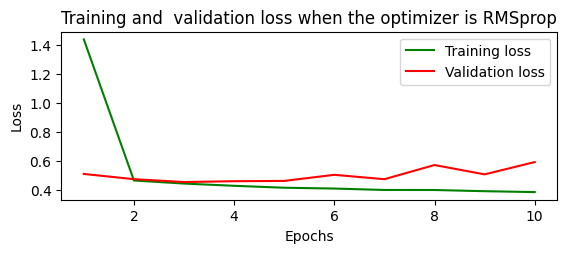

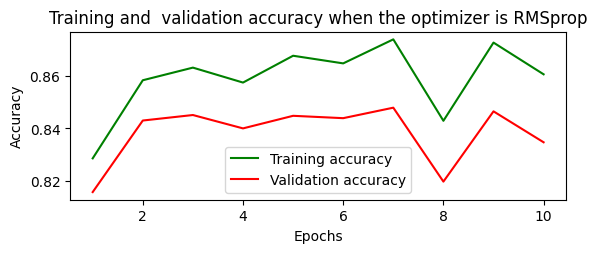

In [36]:
# Plotting the training and validation loss values
epochs = np.arange(10) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and  validation loss when the optimizer is RMSprop")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Plotting the training and validation accuracy values
plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and  validation accuracy when the optimizer is RMSprop")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()